In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [17]:
# https://www.kaggle.com/datasets/thedevastator/kyiv-ukraine-weather-statistics
# Data is in the range [1881-01-01, 2017-10-16]
# ------------------------------------------
#| Column name |	Description            |
#|------------------------------------------
#| PRCP        |Precipitation (Float)      |
#| SNWD	       |Snow Depth (Float)         |
#| TAVG	       |Average Temperature (Float)|
#| TMAX	       |Maximum Temperature (Float)|
#| TMIN	       |Minimum Temperature (Float)|
#| century     |Century (Integer)          |
#| date	       |Date (String)              |
#| month       |Month (String)             |
#| month_no    |Month Number (Integer)     |
#| year	       |Year (Integer)             |
#-------------------------------------------

df = pd.read_csv('../tests/testdata/weather_kyiv.csv')
df = df[['PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'date']]
df['date'] = pd.to_datetime(df['date'])
df['date (Month)'] = df['date'].dt.month
df['date (Year)'] = df['date'].dt.year
df['date (Day of the Month)'] = df['date'].dt.day

In [18]:
# pre process data to remove any nans
# Try to replace nan with a median value across the history for this particular day of particular month.
for day in range(1, 32):
    for month in range(1, 13):
        condition = (df['date (Month)'] == month) & (df['date (Day of the Month)'] == day)
        df.loc[condition, 'PRCP'] = df.loc[condition, 'PRCP'].fillna(df.loc[condition, 'PRCP'].median())
        df.loc[condition, 'SNWD'] = df.loc[condition, 'SNWD'].fillna(df.loc[condition, 'SNWD'].median())
        df.loc[condition, 'TAVG'] = df.loc[condition, 'TAVG'].fillna(df.loc[condition, 'TAVG'].median())
        df.loc[condition, 'TMAX'] = df.loc[condition, 'TMAX'].fillna(df.loc[condition, 'TMAX'].median())
        df.loc[condition, 'TMIN'] = df.loc[condition, 'TMIN'].fillna(df.loc[condition, 'TMIN'].median())

# If we still have nans do backward fill.
df['PRCP'] = df['PRCP'].bfill()
df['SNWD'] = df['SNWD'].bfill()
df['TAVG'] = df['TAVG'].bfill()
df['TMAX'] = df['TMAX'].bfill()
df['TMIN'] = df['TMIN'].bfill()        

In [19]:
# 4.1 Data Normalization
scaled_data = minmax_scale(df.drop('date', axis=1), feature_range=(-1, 1))
scaled_data = pd.DataFrame(columns=['PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'date (Month)', 'date (Year)', 'date (Day of the Month)'], data=scaled_data)

In [20]:
# 4.2 Define median and biased it on 0
scaled_data = scaled_data - stats.describe(scaled_data)[2]
scaled_data['date'] = df['date']

[Text(0.5, 0, 'Dates'),
 Text(0, 0.5, 'TMAX'),
 Text(0.5, 1.0, 'TMAX Scaled Over Time')]

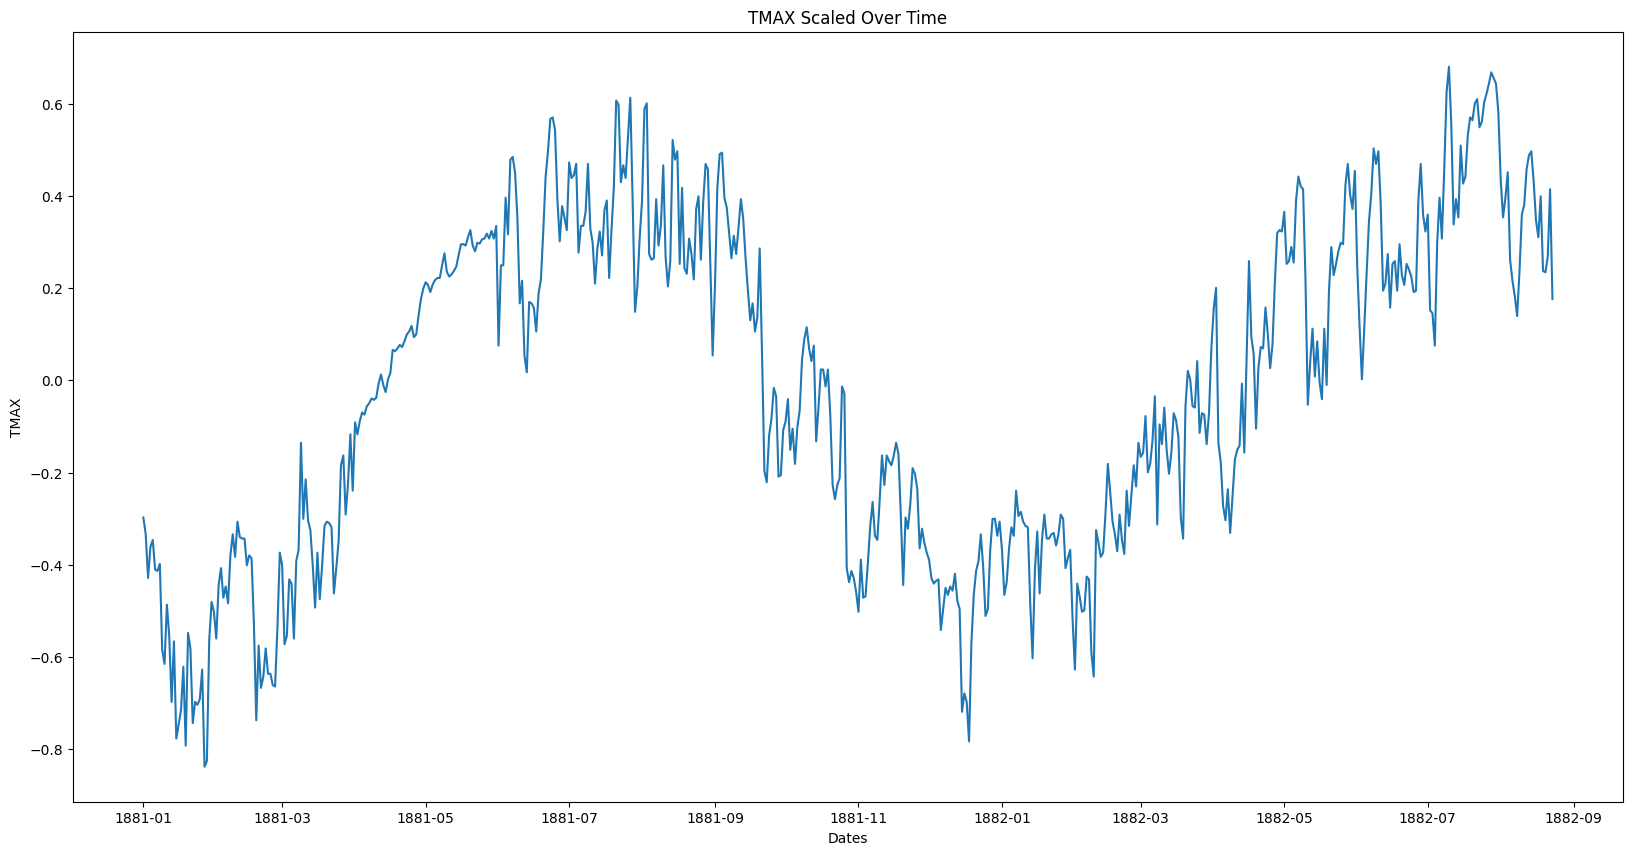

In [21]:
# 4.3 Get the plot of the first 600 time steps
# TMAX is a 3d column, as after scaling pandas DataFrame was transformed to numpy array.
fig, ax = plt.subplots(figsize=[20,10])
ax.plot(scaled_data['date'].values[:600], scaled_data['TMAX'][:600])
ax.set(xlabel='Dates', ylabel='TMAX', title='TMAX Scaled Over Time')

In [22]:
# LAB № 2
# 2.1 Divide 
segment_length = 30
slide_len = 30
segments = []
for start_pos in range(0, scaled_data.shape[0], slide_len):
    end_pos = start_pos + segment_length
    segment = scaled_data['TMAX'].values[start_pos: end_pos].copy()
    if segment.shape[0] != segment_length:
        continue
    segments.append({
        'x': scaled_data['date'].values[start_pos: end_pos],
        'y': segment,
    })
print("Produced %d waveform segments" % len(segments))

Produced 1649 waveform segments


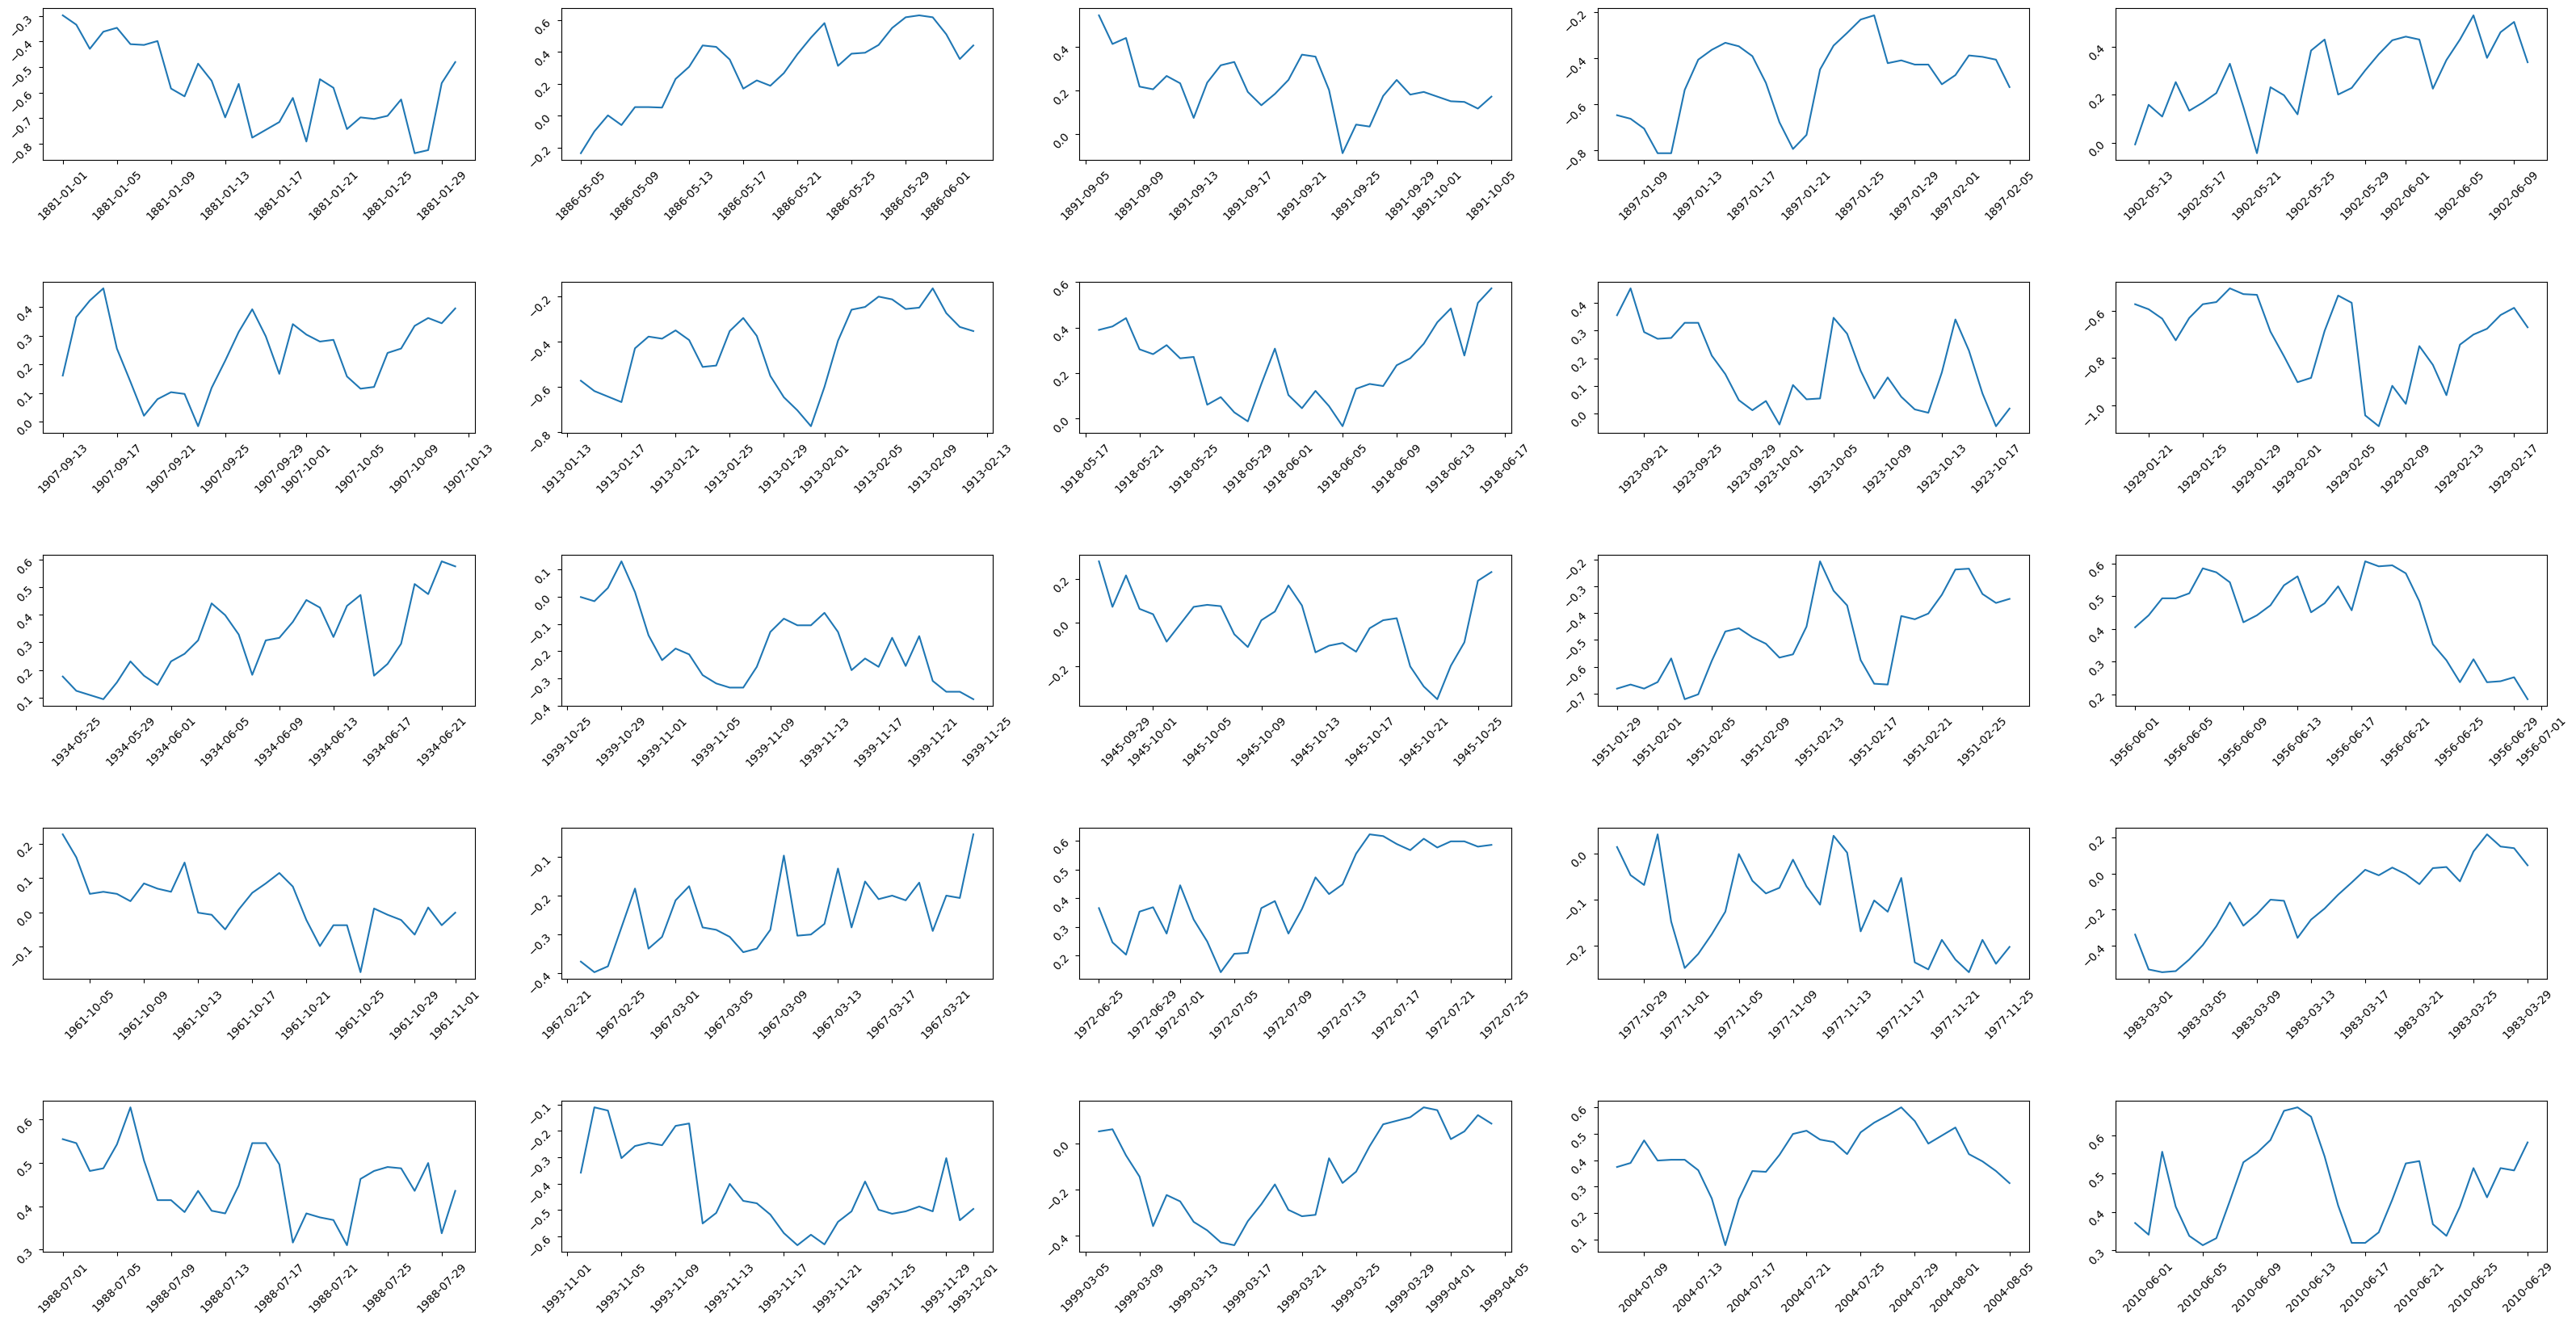

In [23]:
# 2.2 Plot segments
fig, axes = plt.subplots(5,5, figsize=[40,20], )
fig.subplots_adjust(hspace=0.8)
count = 0
step = len(segments) // 25
for i in range(5):
    for j in range(5):
        segment = segments[count]
        axes[i,j].plot(segment['x'], segment['y'])
        axes[i,j].tick_params(labelrotation=45)
        count += step

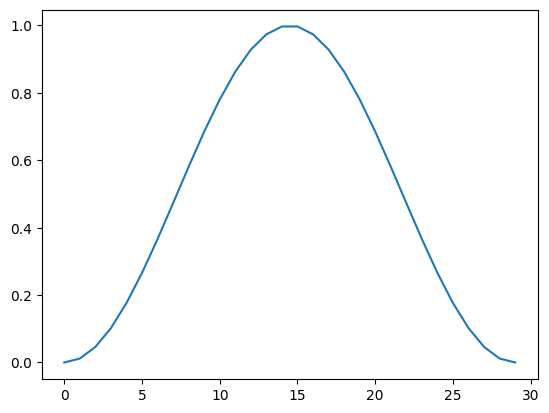

In [24]:
# 3.1 Create a window
window_rads = np.linspace(0, np.pi, segment_length)
window = (np.sin(window_rads)**2)
plt.plot(window)
plt.show()

In [25]:
# 3.2 Apply window function
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment['y']) * window
    windowed_segments.append({
        'y': windowed_segment,
        'x': segment['x'],
    })

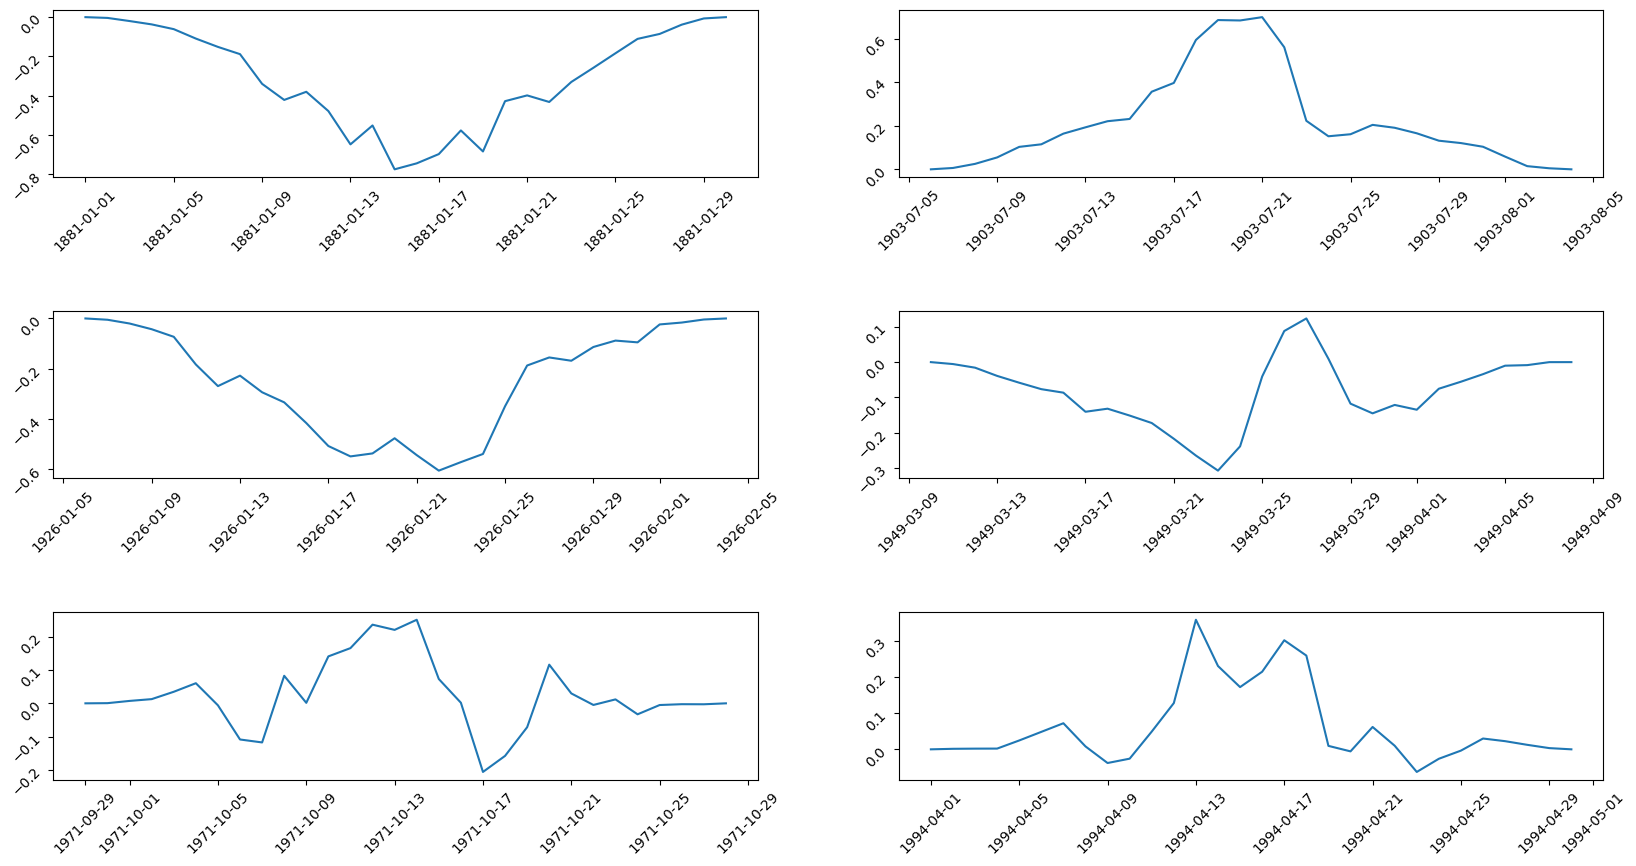

In [26]:
fig, axes = plt.subplots(3,2, figsize=[20,10])
fig.subplots_adjust(hspace=0.8)
step = len(segments) // 6
counter = 0
for i in range(3):
    for j in range(2):
        segment = windowed_segments[counter]
        axes[i,j].plot(segment['x'], segment['y'])
        axes[i,j].tick_params(labelrotation=45)
        counter += step

In [27]:
# Lab №3
from optic_metrology.reader import InmemoryDataSet

In [28]:
dataset = InmemoryDataSet(scaled_data)

In [29]:
dataset.metainfo.types

[<FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.NUMERIC: 1>,
 <FeatureType.DATE: 4>]